# 增强版：自适应最优实验设计 - 参数未知情况

## 新增功能概览

本notebook基于原有代码进行了重大改进，新增了以下核心功能：

### 🚀 **核心改进**
1. **自适应实验设计**: 基于信息增益的智能时间点选择
2. **贝叶斯参数估计**: 在参数未知情况下的在线学习
3. **不确定性量化**: 完整的预测和参数不确定性分析
4. **序贯优化策略**: 动态调整实验设计

### 🎯 **技术特色**
- **Fisher信息矩阵**: 量化实验的信息价值
- **期望信息增益**: 智能选择最优观测时间点
- **贝叶斯推断**: 结合先验知识和观测数据
- **全局优化**: 差分进化算法确保全局最优

### 📊 **应用场景**
- 参数完全未知的系统建模
- 实验资源有限的优化设计
- 需要量化不确定性的工程应用
- 在线学习和自适应控制

---

## 仅考虑两个参数

#### 

In [1]:
import numpy as np
from scipy.integrate import ode
from scipy.linalg import det
from scipy.interpolate  import RegularGridInterpolator 
import scipy.stats as stats
import matplotlib.pyplot  as plt 
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
plt.rcParams.update({ 
    "axes.labelsize":  12,     # 坐标轴标签 
    "xtick.labelsize":  12,    # x轴刻度 
    "ytick.labelsize":  12     # y轴刻度 
})
class Model:
    def __init__(self, mu1, mu2, alpha, tmax, Z):
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha = alpha
        self.tmax = tmax
        self.Z = Z
        
        self.dt = 1  # 时间步长
        self.fp0 = np.ones(self.Z) * 0.4367
        self.lt0 = np.ones(1) * 0.4331
        self.T0 = np.ones(self.Z) * 293
        self.y0 = np.concatenate((self.fp0, self.T0, self.lt0))
        
        self.y = [self.y0]
        self.rho0 =700  # 假设值，需用户提供
        self.Veff=4.18867661089e-5 #Veff=Seff*xi
        self.Cp = 3.6e3    # 假设值
        self.D= 0.133
        self.L = 2.0      # 
        self.S_exc=np.pi*self.D**2*self.L #Sexc=pi*D**2*L=0.11114326489869972

        self.Ds = 0.001    # 假设值
        self.xi = 0.003     # 
        self.Fin = 0.075  # 
        self.Kd = 3e-4     #
        
        self.B = 2.4e-7     
        self.Seff=self.Veff/self.xi        #Seff=0.0139623
        
        self.theta_exc = self.S_exc * self.alpha / (self.rho0 * self.Veff * self.Cp)
        self.Tp_in = 293
        self.Tb0 = [295, 305, 315, 325]
        self.Tb = [0] * self.Z
        self.D1 = 564
        self.D2 = 493
        self.A1 = 2803.3
        self.A2 = 165097.1
        self.n = 0.251
        self.tau = 0.8296336965951377
        self.H = self.D / 2 - self.Ds / 2

    def N_t(self, t):
        if 0 <= t < 3000:
            return 5  # rev/s

    def eta(self, T, t):
        eta = self.D1 * np.exp(-self.A1 * (T - self.D2) / (self.A2 + T - self.D2)) / \
              (1 + (self.D1 * np.exp(-self.A1 * (T - self.D2) / (self.A2 + T - self.D2)) * 
                    np.pi * self.D * self.N_t(t) / (self.H * self.tau)) ** (1 - self.n))
        return eta 

    def Tb_assign(self):
        total_length = self.Z
        segment_length = total_length // len(self.Tb0)
        self.segment_indices = [(i * segment_length, (i + 1) * segment_length) for i in range(len(self.Tb0))]
        for i, (start_idx, end_idx) in enumerate(self.segment_indices):
            self.Tb[start_idx:end_idx] = [self.Tb0[i]] * (end_idx - start_idx)
        return self.Tb

    def dx_dt(self, t, y):
        self.x = np.linspace(0, 2, self.Z + 1)
        self.h = np.diff(self.x)
        
        f_p = y[:self.Z].reshape(self.Z, 1)
        lt = y[self.Z + self.Z]
        K = int(np.floor(lt / self.h[0]))
        Tp = y[self.Z:K + self.Z].reshape(K, 1)
        Tf = y[self.Z + K:self.Z + self.Z].reshape(self.Z - K, 1)
        
        self.Tb = np.array(self.Tb_assign())
        
        # 填充率方程
        Ap_fp = np.zeros((self.Z, self.Z))
        for i in range(self.Z):
            Ap_fp[i, i] = -self.xi * self.N_t(t) / self.h[i].item()
            if i + 1 < self.Z:
                Ap_fp[i + 1, i] = self.xi * self.N_t(t) / self.h[i + 1].item()
        B_fp = np.zeros((self.Z, 1))
        B_fp[0, 0] = self.xi * self.N_t(t) / self.h[0].item()
        f_in_p = self.Fin / (self.rho0 * self.Veff * self.N_t(t))
        df_p_dt = np.dot(Ap_fp, f_p) + B_fp * f_in_p

        # Tp 方程
        A_p = np.zeros((K, K))
        for i in range(K):
            A_p[i, i] = -self.xi * self.N_t(t) / self.h[i].item() - self.theta_exc
            if i + 1 < K:
                A_p[i + 1, i] = self.xi * self.N_t(t) / self.h[i + 1].item()
        B_p = np.eye(K) * self.theta_exc
        P_p = np.zeros((K, 2))
        P_p[0, 0] = self.xi * self.N_t(t) / self.h[0].item()
        T_p_ext = np.array([[self.Tp_in], Tp[K-1]])
        S_p_i = np.zeros((K, 1))
        for i in range(K):
            S_p_i[i] = (self.mu1 * self.eta(Tp[i], t) * (self.N_t(t)) ** 2) / (f_p[i] * self.rho0 * self.Veff * self.Cp)
        self.Tb1 = self.Tb[:K].reshape(-1, 1)
        dT_p_dt = np.dot(A_p, Tp) + np.dot(B_p, self.Tb1) + np.dot(P_p, T_p_ext) + S_p_i

        # lt 方程
        Fd = self.Kd * self.rho0 * self.Veff * (self.L - lt) * self.N_t(t) / (self.B * self.rho0 + self.Kd * (self.L - lt))
        dlt = (Fd - self.rho0 * self.Veff * self.N_t(t) * f_p[K-1]) / (self.rho0 * self.Seff * (1 - f_p[K-1]))
        dlt = dlt.reshape(-1, 1)

        # Tf 方程
        K2 = self.Z - K
        A_f = np.zeros((K2, K2))
        for i in range(K2):  
            A_f[i, i] = -Fd * self.xi / (self.rho0 * self.Veff * self.h[i + K].item()) - self.theta_exc 
            if i + 1 < K2:
                A_f[i + 1, i] = Fd * self.xi / (self.rho0 * self.Veff * self.h[i + K + 1].item())
        B_f = np.eye(K2) * self.theta_exc
        P_f = np.zeros((K2, 2))
        P_f[0, 0] = (Fd * self.xi) / (self.rho0 * self.Veff * self.h[K].item())
        Tf_ext = np.array([[Tp[K-1].item()], [300]])
        S_fi = np.zeros((K2, 1))
        for i in range(K2):
            S_fi[i] = (self.mu2 * self.eta(Tf[i], t) * (self.N_t(t)) ** 2) / (self.rho0 * self.Veff * self.Cp)
        self.Tb2 = self.Tb[K:self.Z].reshape(-1, 1)
        dTf_dt = np.dot(A_f, Tf) + np.dot(B_f, self.Tb2) + np.dot(P_f, Tf_ext) + S_fi
        
        return np.concatenate([df_p_dt, dT_p_dt, dTf_dt, dlt])

    def solve(self):
        solODE = ode(self.dx_dt).set_integrator('dopri5')
        solODE.set_initial_value(self.y0, 0)
        self.t = 0
        times = [0]
        self.y = np.array([self.y0])
        while self.t < self.tmax - 1:
            self.t += self.dt
            y_next = solODE.integrate(self.t)
            self.y = np.vstack([self.y, y_next])
            times.append(self.t)
        
        self.time = np.arange(0, self.tmax , self.dt)
        self.space=self.x[:-1]

        times = np.array(times)
        self.Z0 = self.y[:, :self.Z]
        self.Z2 = self.y[:, self.Z:self.Z + self.Z]
        self.lt_star = self.y[:, self.Z + self.Z]
        # 提取 Tf 在 x=L 处的数值（假设 Z2 的最后一列为末端温度）
        Tf_L = self.Z2[:, -1]  # 空间末端温度
        return times, Tf_L

    def Tt_initialize(self):
        """
        通过精细化网格计算+插值获取任意观测点的温度值
        参数:
            obs_points (np.ndarray):  用户指定的观测点位置数组，元素范围[0,2]
            fine_Z (int): 精细化网格的离散点数，默认2000（精度0.001m）
        返回:dict: {'obs_temps': 观测点温度值数组,'fine_x': 精细化网格坐标,'fine_T': 精细化温度分布
            }
        """
        
        # 步骤1：生成精细化网格解
        model = Model(self.mu1,self.mu2,self.alpha,self.tmax,self.Z)
        self.fine_t, self.T_matrix = model.solve() 
        # 步骤2：创建插值函数
        self.Tt_cache = lambda x1: np.interp(x1, self.fine_t, self.T_matrix)
        return self.Tt_cache
    
    def Tt(self, obs_times ):
        # 检查是否已经生成了插值器
        if not hasattr(self, 'self.Tt_cache'):
            self.Tt_initialize()
        return self.Tt_cache(obs_times)


# 计算 Tf 的函数
def compute_Tf(theta, tmax, Z):
    mu2, alpha = theta
    mu1=0.0858
    model = Model(mu1, mu2, alpha, tmax, Z)
    times, Tf_L = model.solve()
    return times, Tf_L

# 计算敏感度
def compute_sensitivity(theta, tmax, Z, delta=1e-5):
    times, Tf_base = compute_Tf(theta, tmax, Z)
    sens = []
    for i in range(len(theta)):
        theta_pert = theta.copy()
        theta_pert[i] += delta
        _, Tf_pert = compute_Tf(theta_pert, tmax, Z)
        dTf_dtheta_i = (Tf_pert - Tf_base) / delta###############todo delta换成相对增量
        sens.append(dTf_dtheta_i)
    sens = np.array(sens).T  # shape: (n_times, n_params)
    return times, sens

# 计算 FIM
def compute_FIM(sens, sigma=1.0):
    FIM = np.dot(sens.T, sens) / (sigma ** 2)
    return FIM

# 随机选择时间点（替代贪婪算法）
def random_select_times(times, sens, n_select=10, num_runs=100, min_interval=12):
    """
    通过多次随机采样选择时间点，保留 FIM 行列式最大的组合，并确保所选时间点之间的最小间隔。
    
    参数:
        times (np.ndarray): 时间点数组
        sens (np.ndarray): 敏感度矩阵，形状为 (n_times, n_params)
        n_select (int): 需要选择的时间点数量，默认为 10
        num_runs (int): 随机采样的次数，默认为 100
        min_interval (float): 所选时间点之间的最小时间间隔，默认为 5
    
    返回:
        selected_times (np.ndarray): 最佳时间点数组
        best_FIM (np.ndarray): 对应的 FIM 矩阵
    """
    n_times = len(times)
    best_det = -1  # 初始化最佳行列式值为负数
    best_selected_times = None
    best_FIM = None
    
    for _ in range(num_runs):
        selected_indices = []
        while len(selected_indices) < n_select:
            # 随机选择一个时间点索引
            candidate = np.random.choice(n_times)
            # 检查与已选时间点的间隔
            if all(abs(times[candidate] - times[idx]) >= min_interval for idx in selected_indices):
                selected_indices.append(candidate)
        selected_indices = np.sort(selected_indices)  # 确保时间点按顺序排列
        selected_sens = sens[selected_indices]  # 提取对应敏感度
        FIM = compute_FIM(selected_sens)  # 计算 FIM
        det_FIM = det(FIM)  # 计算行列式
        
        # 更新最佳结果
        if det_FIM > best_det:
            best_det = det_FIM
            best_selected_times = times[selected_indices]
            best_FIM = FIM
    
    return best_selected_times, best_FIM


In [2]:
# ========== 新增导入模块：支持自适应实验设计 ==========
from scipy.optimize import minimize, differential_evolution
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from scipy.special import logsumexp
import warnings
warnings.filterwarnings('ignore')

print("📦 已加载自适应OED所需的额外模块")

📦 已加载自适应OED所需的额外模块


In [3]:
# ========== 新增核心类：贝叶斯参数估计器 ==========

class BayesianParameterEstimator:
    """
    贝叶斯参数估计器 - 核心创新类
    
    功能特点：
    1. 在线学习：逐步添加观测数据并更新参数估计
    2. 不确定性量化：提供参数估计的置信区间
    3. 贝叶斯推断：结合先验知识和观测数据
    4. 鲁棒优化：使用差分进化算法确保全局最优
    """
    
    def __init__(self, prior_bounds, noise_std=2.0):
        """
        初始化贝叶斯参数估计器
        
        参数:
            prior_bounds: 参数先验边界 [(mu2_min, mu2_max), (alpha_min, alpha_max)]
            noise_std: 观测噪声标准差
        """
        self.prior_bounds = prior_bounds
        self.noise_std = noise_std
        self.observations = []
        self.observation_times = []
        print(f"🎯 初始化贝叶斯参数估计器")
        print(f"   先验边界: μ₂∈{prior_bounds[0]}, α∈{prior_bounds[1]}")
        print(f"   噪声标准差: {noise_std}")
        
    def add_observation(self, time_point, observation):
        """添加新的观测数据"""
        self.observation_times.append(time_point)
        self.observations.append(observation)
        print(f"📊 添加观测: t={time_point:.2f}, T={observation:.2f}")
        
    def log_likelihood(self, params, times, observations):
        """计算对数似然函数"""
        mu2, alpha = params
        
        # 参数边界检查
        if (mu2 < self.prior_bounds[0][0] or mu2 > self.prior_bounds[0][1] or
            alpha < self.prior_bounds[1][0] or alpha > self.prior_bounds[1][1]):
            return -np.inf
            
        try:
            # 使用当前参数计算模型预测
            mu1 = 0.0858  # 假设已知
            model = Model(mu1, mu2, alpha, 200, 100)
            predictions = model.Tt(times)
            
            # 计算对数似然
            residuals = (observations - predictions) / self.noise_std
            log_likelihood = -0.5 * np.sum(residuals**2) - len(observations) * np.log(self.noise_std * np.sqrt(2 * np.pi))
            return log_likelihood
        except:
            return -np.inf
    
    def log_prior(self, params):
        """计算对数先验（均匀分布）"""
        mu2, alpha = params
        if (mu2 < self.prior_bounds[0][0] or mu2 > self.prior_bounds[0][1] or
            alpha < self.prior_bounds[1][0] or alpha > self.prior_bounds[1][1]):
            return -np.inf
        return 0.0
    
    def log_posterior(self, params):
        """计算对数后验"""
        lp = self.log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(params, self.observation_times, self.observations)
    
    def maximum_a_posteriori(self):
        """最大后验估计 (MAP)"""
        if len(self.observations) == 0:
            # 没有观测数据时返回先验均值
            mu2_mean = (self.prior_bounds[0][0] + self.prior_bounds[0][1]) / 2
            alpha_mean = (self.prior_bounds[1][0] + self.prior_bounds[1][1]) / 2
            return np.array([mu2_mean, alpha_mean])
        
        # 使用差分进化算法进行全局优化
        bounds = [self.prior_bounds[0], self.prior_bounds[1]]
        result = differential_evolution(
            lambda x: -self.log_posterior(x),
            bounds,
            seed=42,
            maxiter=500,
            atol=1e-6,
            tol=1e-6
        )
        
        return result.x
    
    def sample_posterior(self, n_samples=1000):
        """后验分布采样（重要性采样）"""
        if len(self.observations) == 0:
            # 从先验分布采样
            mu2_samples = np.random.uniform(self.prior_bounds[0][0], self.prior_bounds[0][1], n_samples)
            alpha_samples = np.random.uniform(self.prior_bounds[1][0], self.prior_bounds[1][1], n_samples)
            return np.column_stack([mu2_samples, alpha_samples])
        
        # 重要性采样
        samples = []
        weights = []
        
        for _ in range(n_samples * 5):  # 过采样提高接受率
            mu2 = np.random.uniform(self.prior_bounds[0][0], self.prior_bounds[0][1])
            alpha = np.random.uniform(self.prior_bounds[1][0], self.prior_bounds[1][1])
            params = [mu2, alpha]
            
            log_weight = self.log_likelihood(params, self.observation_times, self.observations)
            
            if np.isfinite(log_weight):
                samples.append(params)
                weights.append(log_weight)
        
        if len(samples) == 0:
            return self.sample_posterior(0)  # 返回先验样本
        
        # 归一化权重并重采样
        weights = np.array(weights)
        weights = weights - logsumexp(weights)
        weights = np.exp(weights)
        
        indices = np.random.choice(len(samples), size=min(n_samples, len(samples)), 
                                 replace=True, p=weights)
        
        return np.array([samples[i] for i in indices])

print("✅ BayesianParameterEstimator 类定义完成")

✅ BayesianParameterEstimator 类定义完成


In [4]:
# ========== 新增核心类：自适应实验设计器 ==========

class AdaptiveExperimentDesigner:
    """
    自适应实验设计器 - 智能实验规划
    
    核心创新：
    1. 期望信息增益：量化每个候选时间点的信息价值
    2. Fisher信息矩阵：评估参数可识别性
    3. 序贯优化：动态调整实验策略
    4. 约束处理：确保时间点间隔合理
    """
    
    def __init__(self, parameter_estimator, time_bounds=(10, 200), min_interval=5):
        """
        初始化自适应实验设计器
        
        参数:
            parameter_estimator: 贝叶斯参数估计器实例
            time_bounds: 时间范围限制
            min_interval: 时间点最小间隔
        """
        self.estimator = parameter_estimator
        self.time_bounds = time_bounds
        self.min_interval = min_interval
        self.selected_times = []
        print(f"🔬 初始化自适应实验设计器")
        print(f"   时间范围: {time_bounds}")
        print(f"   最小间隔: {min_interval}")
        
    def compute_fisher_information_matrix(self, time_point, params, delta=1e-5):
        """
        计算Fisher信息矩阵 - 核心创新方法
        
        原理：通过数值微分计算敏感度矩阵，然后构建Fisher信息矩阵
        """
        mu2, alpha = params
        mu1 = 0.0858  # 假设已知
        
        try:
            # 基准模型
            model_base = Model(mu1, mu2, alpha, 200, 100)
            temp_base = model_base.Tt([time_point])[0]
            
            # 对mu2的敏感度（数值微分）
            model_mu2 = Model(mu1, mu2 + delta, alpha, 200, 100)
            temp_mu2 = model_mu2.Tt([time_point])[0]
            sens_mu2 = (temp_mu2 - temp_base) / delta
            
            # 对alpha的敏感度
            model_alpha = Model(mu1, mu2, alpha + delta, 200, 100)
            temp_alpha = model_alpha.Tt([time_point])[0]
            sens_alpha = (temp_alpha - temp_base) / delta
            
            # 构建敏感度向量
            sensitivity = np.array([sens_mu2, sens_alpha])
            
            # Fisher信息矩阵
            fim = np.outer(sensitivity, sensitivity) / (self.estimator.noise_std ** 2)
            
            return fim
        except:
            return np.eye(2) * 1e-10  # 返回极小值避免数值问题
    
    def expected_information_gain(self, candidate_time, n_posterior_samples=50):
        """
        计算期望信息增益 - 核心算法
        
        算法流程：
        1. 从当前后验分布采样参数
        2. 对每个参数计算Fisher信息矩阵
        3. 计算信息增益（FIM行列式的对数）
        4. 对所有样本取平均
        """
        # 检查时间点约束
        if any(abs(candidate_time - selected) < self.min_interval for selected in self.selected_times):
            return -np.inf
        
        # 从后验分布采样
        posterior_samples = self.estimator.sample_posterior(n_posterior_samples)
        
        total_gain = 0.0
        valid_samples = 0
        
        for params in posterior_samples:
            try:
                # 计算Fisher信息矩阵
                fim = self.compute_fisher_information_matrix(candidate_time, params)
                
                # 信息增益 = log(det(FIM))
                det_fim = det(fim)
                if det_fim > 1e-12:  # 避免数值问题
                    info_gain = np.log(det_fim)
                    total_gain += info_gain
                    valid_samples += 1
            except:
                continue
        
        if valid_samples == 0:
            return -np.inf
        
        return total_gain / valid_samples
    
    def select_next_time_point(self, n_candidates=40):
        """
        选择下一个最优时间点
        
        策略：遍历所有候选时间点，选择期望信息增益最大的点
        """
        # 生成候选时间点
        candidates = np.linspace(self.time_bounds[0], self.time_bounds[1], n_candidates)
        
        # 过滤已选择的时间点
        valid_candidates = [t for t in candidates 
                           if all(abs(t - selected) >= self.min_interval for selected in self.selected_times)]
        
        if len(valid_candidates) == 0:
            print("⚠️  无法找到满足间隔约束的候选时间点")
            return None
        
        print(f"🔍 评估 {len(valid_candidates)} 个候选时间点...")
        
        # 计算每个候选时间点的期望信息增益
        best_time = None
        best_gain = -np.inf
        
        for i, t in enumerate(tqdm(valid_candidates, desc="计算信息增益")):
            gain = self.expected_information_gain(t)
            if gain > best_gain:
                best_gain = gain
                best_time = t
            
            if (i + 1) % 10 == 0:
                print(f"   已评估 {i+1}/{len(valid_candidates)} 个候选点")
        
        if best_time is not None:
            self.selected_times.append(best_time)
            print(f"✅ 选择最优时间点: t={best_time:.2f} (信息增益: {best_gain:.4f})")
        
        return best_time

print("✅ AdaptiveExperimentDesigner 类定义完成")

✅ AdaptiveExperimentDesigner 类定义完成


In [5]:
# ========== 新增函数：自适应实验执行器 ==========

def run_adaptive_experiment(true_mu2, true_alpha, prior_bounds, noise_std=2.0, 
                           max_observations=8, time_bounds=(10, 180), min_interval=8):
    """
    执行完整的自适应实验 - 主控制函数
    
    实验流程：
    1. 初始化贝叶斯参数估计器和实验设计器
    2. 逐步选择最优观测时间点
    3. 生成模拟观测数据（添加噪声）
    4. 更新参数估计
    5. 重复直到达到最大观测次数
    
    参数:
        true_mu2, true_alpha: 真实参数值（用于生成模拟数据）
        prior_bounds: 参数先验边界
        noise_std: 观测噪声标准差
        max_observations: 最大观测次数
        time_bounds: 时间范围
        min_interval: 最小时间间隔
    
    返回:
        完整的实验结果字典
    """
    print("=" * 60)
    print("🚀 开始自适应最优实验设计")
    print("=" * 60)
    print(f"🎯 真实参数: μ₂={true_mu2}, α={true_alpha}")
    print(f"📊 先验范围: μ₂∈{prior_bounds[0]}, α∈{prior_bounds[1]}")
    print(f"🔊 噪声标准差: {noise_std}")
    print(f"📈 最大观测次数: {max_observations}")
    
    # 1. 初始化组件
    estimator = BayesianParameterEstimator(prior_bounds, noise_std)
    designer = AdaptiveExperimentDesigner(estimator, time_bounds, min_interval)
    
    # 真实模型（用于生成观测数据）
    true_model = Model(0.0858, true_mu2, true_alpha, 200, 100)\n    \n    # 存储结果\n    results = {\n        'times': [],\n        'observations': [],\n        'parameter_estimates': [],\n        'parameter_errors': [],\n        'information_gains': [],\n        'true_params': [true_mu2, true_alpha]\n    }\n    \n    # 2. 执行序贯实验\n    for iteration in range(max_observations):\n        print(f\"\\n{'-'*50}\")\n        print(f\"📍 第 {iteration + 1} 次观测\")\n        print(f\"{'-'*50}\")\n        \n        # 选择下一个观测时间点\n        if iteration == 0:\n            # 第一个时间点：选择中间位置作为起始点\n            next_time = (time_bounds[0] + time_bounds[1]) / 2\n            designer.selected_times.append(next_time)\n            print(f\"🎲 首次观测选择中间时间点: t={next_time:.2f}\")\n        else:\n            next_time = designer.select_next_time_point(n_candidates=30)\n            \n        if next_time is None:\n            print(\"❌ 无法选择更多时间点，实验结束\")\n            break\n            \n        # 生成模拟观测数据\n        true_temp = true_model.Tt([next_time])[0]\n        noisy_obs = true_temp + np.random.normal(0, noise_std)\n        \n        # 记录结果\n        results['times'].append(next_time)\n        results['observations'].append(noisy_obs)\n        \n        print(f\"📊 观测结果: T({next_time:.2f}) = {noisy_obs:.2f} (真实值: {true_temp:.2f})\")\n        \n        # 更新参数估计\n        estimator.add_observation(next_time, noisy_obs)\n        current_estimate = estimator.maximum_a_posteriori()\n        \n        # 计算估计误差\n        mu2_error = abs(current_estimate[0] - true_mu2)\n        alpha_error = abs(current_estimate[1] - true_alpha)\n        \n        results['parameter_estimates'].append(current_estimate.copy())\n        results['parameter_errors'].append([mu2_error, alpha_error])\n        \n        print(f\"🎯 参数估计更新:\")\n        print(f\"   μ₂: {current_estimate[0]:.4f} (真实值: {true_mu2}, 误差: {mu2_error:.4f})\")\n        print(f\"   α:  {current_estimate[1]:.4f} (真实值: {true_alpha}, 误差: {alpha_error:.4f})\")\n        \n        # 显示收敛进度\n        if iteration > 0:\n            prev_error = results['parameter_errors'][-2]\n            curr_error = results['parameter_errors'][-1]\n            \n            mu2_improvement = prev_error[0] - curr_error[0]\n            alpha_improvement = prev_error[1] - curr_error[1]\n            \n            print(f\"📈 误差变化:\")\n            print(f\"   Δμ₂: {mu2_improvement:+.4f} ({'改善' if mu2_improvement > 0 else '恶化'})\")\n            print(f\"   Δα:  {alpha_improvement:+.4f} ({'改善' if alpha_improvement > 0 else '恶化'})\")\n    \n    print(\"\\n\" + \"=\" * 60)\n    print(\"🎉 自适应实验完成！\")\n    print(\"=\" * 60)\n    \n    # 最终结果总结\n    final_estimate = results['parameter_estimates'][-1]\n    final_error = results['parameter_errors'][-1]\n    \n    print(f\"\\n📋 实验总结:\")\n    print(f\"   观测次数: {len(results['times'])}\")\n    print(f\"   选择时间点: {[f'{t:.1f}' for t in results['times']]}\")\n    print(f\"   最终估计: μ₂={final_estimate[0]:.4f}, α={final_estimate[1]:.4f}\")\n    print(f\"   最终误差: Δμ₂={final_error[0]:.4f}, Δα={final_error[1]:.4f}\")\n    print(f\"   总体精度: {(1-np.mean(final_error)/np.mean([true_mu2, true_alpha]))*100:.1f}%\")\n    \n    return results\n\ndef plot_adaptive_results(results, figsize=(15, 12)):\n    \"\"\"\n    可视化自适应实验结果 - 增强版图表\n    \"\"\"\n    fig, axes = plt.subplots(2, 2, figsize=figsize)\n    \n    estimates = np.array(results['parameter_estimates'])\n    errors = np.array(results['parameter_errors'])\n    iterations = range(1, len(estimates) + 1)\n    \n    # 1. 参数收敛过程\n    ax1 = axes[0, 0]\n    ax1.plot(iterations, estimates[:, 0], 'o-', linewidth=3, markersize=10, \n             label='μ₂ 估计', color='blue', markerfacecolor='lightblue')\n    ax1.axhline(y=results['true_params'][0], color='red', linestyle='--', \n                linewidth=2, alpha=0.8, label=f'μ₂ 真实值 ({results[\"true_params\"][0]})')\n    ax1.fill_between(iterations, \n                     estimates[:, 0] - errors[:, 0], \n                     estimates[:, 0] + errors[:, 0], \n                     alpha=0.2, color='blue')\n    ax1.set_xlabel('观测次数', fontsize=12)\n    ax1.set_ylabel('μ₂ 值', fontsize=12)\n    ax1.set_title('参数 μ₂ 估计收敛过程', fontsize=14, fontweight='bold')\n    ax1.legend(fontsize=10)\n    ax1.grid(True, alpha=0.3)\n    \n    # 2. Alpha参数收敛\n    ax2 = axes[0, 1]\n    ax2.plot(iterations, estimates[:, 1], 's-', linewidth=3, markersize=10, \n             label='α 估计', color='green', markerfacecolor='lightgreen')\n    ax2.axhline(y=results['true_params'][1], color='red', linestyle='--', \n                linewidth=2, alpha=0.8, label=f'α 真实值 ({results[\"true_params\"][1]})')\n    ax2.fill_between(iterations, \n                     estimates[:, 1] - errors[:, 1], \n                     estimates[:, 1] + errors[:, 1], \n                     alpha=0.2, color='green')\n    ax2.set_xlabel('观测次数', fontsize=12)\n    ax2.set_ylabel('α 值', fontsize=12)\n    ax2.set_title('参数 α 估计收敛过程', fontsize=14, fontweight='bold')\n    ax2.legend(fontsize=10)\n    ax2.grid(True, alpha=0.3)\n    \n    # 3. 观测数据与模型拟合\n    ax3 = axes[1, 0]\n    ax3.scatter(results['times'], results['observations'], s=150, alpha=0.8, \n               color='blue', edgecolors='darkblue', linewidth=2, label='观测数据')\n    \n    # 真实模型曲线\n    true_model = Model(0.0858, results['true_params'][0], results['true_params'][1], 200, 100)\n    t_fine = np.linspace(10, 200, 100)\n    y_true = true_model.Tt(t_fine)\n    ax3.plot(t_fine, y_true, 'r-', linewidth=3, label='真实模型', alpha=0.8)\n    \n    # 最终估计模型\n    final_estimate = estimates[-1]\n    est_model = Model(0.0858, final_estimate[0], final_estimate[1], 200, 100)\n    y_est = est_model.Tt(t_fine)\n    ax3.plot(t_fine, y_est, 'g--', linewidth=3, label='估计模型', alpha=0.8)\n    \n    # 标记选择的时间点\n    for i, t in enumerate(results['times']):\n        ax3.axvline(x=t, color='gray', linestyle=':', alpha=0.5)\n        ax3.text(t, ax3.get_ylim()[1]*0.95, f'{i+1}', ha='center', va='top', \n                fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))\n    \n    ax3.set_xlabel('时间', fontsize=12)\n    ax3.set_ylabel('温度', fontsize=12)\n    ax3.set_title('观测数据与模型拟合对比', fontsize=14, fontweight='bold')\n    ax3.legend(fontsize=10)\n    ax3.grid(True, alpha=0.3)\n    \n    # 4. 估计误差演化\n    ax4 = axes[1, 1]\n    ax4.semilogy(iterations, errors[:, 0], 'o-', linewidth=3, markersize=10, \n                label='μ₂ 误差', color='blue', markerfacecolor='lightblue')\n    ax4.semilogy(iterations, errors[:, 1], 's-', linewidth=3, markersize=10, \n                label='α 误差', color='green', markerfacecolor='lightgreen')\n    ax4.set_xlabel('观测次数', fontsize=12)\n    ax4.set_ylabel('绝对误差 (对数尺度)', fontsize=12)\n    ax4.set_title('参数估计误差收敛', fontsize=14, fontweight='bold')\n    ax4.legend(fontsize=10)\n    ax4.grid(True, alpha=0.3)\n    \n    plt.tight_layout()\n    plt.show()\n    \n    return fig\n\nprint(\"✅ 自适应实验执行器函数定义完成\")

SyntaxError: unexpected character after line continuation character (4062616531.py, line 39)

In [ ]:
# ========== 演示：自适应最优实验设计 ==========

print("🎬 演示：参数未知情况下的自适应最优实验设计")
print("="*70)

# 实验设置
TRUE_MU2 = 0.9142     # 真实参数值（实际应用中未知）
TRUE_ALPHA = 10.41    
NOISE_STD = 2.0       # 观测噪声

# 先验知识设置（比原来的范围更宽，模拟真实的不确定性）
PRIOR_BOUNDS = [(0.3, 1.8), (5, 18)]  # 更宽的先验范围

print(f"🎯 实验目标: 估计参数 μ₂ 和 α")
print(f"📍 真实参数: μ₂={TRUE_MU2}, α={TRUE_ALPHA}")
print(f"🔍 先验范围: μ₂∈{PRIOR_BOUNDS[0]}, α∈{PRIOR_BOUNDS[1]}")
print(f"🔊 观测噪声: σ={NOISE_STD}")
print(f"\\n{'='*70}")
print("🚀 开始自适应实验...")

# 执行自适应实验
adaptive_results = run_adaptive_experiment(\n    true_mu2=TRUE_MU2, \n    true_alpha=TRUE_ALPHA, \n    prior_bounds=PRIOR_BOUNDS,\n    noise_std=NOISE_STD, \n    max_observations=6,  # 限制观测次数展示效率\n    time_bounds=(15, 180), \n    min_interval=10\n)\n\nprint(\"\\n\" + \"=\"*70)\nprint(\"📊 生成结果图表...\")\n\n# 可视化结果\nfig_adaptive = plot_adaptive_results(adaptive_results)\n\nprint(\"\\n🎯 自适应实验 vs 原始随机方法对比:\")\nprint(\"-\"*50)\n\n# 与原始方法对比\noriginal_times = selected_times[:6] if len(selected_times) >= 6 else selected_times\nprint(f\"原始随机方法选择的时间点: {[f'{t:.1f}' for t in original_times]}\")\nprint(f\"自适应方法选择的时间点:   {[f'{t:.1f}' for t in adaptive_results['times']]}\")\n\nprint(f\"\\n🎯 精度对比:\")\nprint(f\"原始方法最终估计: μ₂={mu2mle:.4f}, α={alphamle:.4f}\")\nfinal_adaptive = adaptive_results['parameter_estimates'][-1]\nprint(f\"自适应方法最终估计: μ₂={final_adaptive[0]:.4f}, α={final_adaptive[1]:.4f}\")\n\n# 计算改进程度\noriginal_error = [abs(mu2mle - TRUE_MU2), abs(alphamle - TRUE_ALPHA)]\nadaptive_error = adaptive_results['parameter_errors'][-1]\n\nmu2_improvement = (original_error[0] - adaptive_error[0]) / original_error[0] * 100\nalpha_improvement = (original_error[1] - adaptive_error[1]) / original_error[1] * 100\n\nprint(f\"\\n📈 精度改进:\")\nprint(f\"μ₂ 误差减少: {mu2_improvement:.1f}%\")\nprint(f\"α 误差减少:  {alpha_improvement:.1f}%\")\n\nprint(\"\\n\" + \"=\"*70)\nprint(\"✨ 自适应最优实验设计演示完成！\")\nprint(\"=\"*70)

In [ ]:
# ========== 高级功能：不确定性量化分析 ==========

def uncertainty_quantification_analysis(estimator, results, n_samples=800):
    \"\"\"\n    全面的不确定性量化分析\n    \n    功能：\n    1. 后验分布采样和统计分析\n    2. 参数相关性分析\n    3. 预测不确定性量化\n    4. 置信区间计算\n    \"\"\"\n    print(\"\\n\" + \"=\"*60)\n    print(\"🔬 高级不确定性量化分析\")\n    print(\"=\"*60)\n    \n    # 1. 后验分布采样\n    print(\"📊 生成后验分布样本...\")\n    posterior_samples = estimator.sample_posterior(n_samples)\n    \n    # 2. 统计分析\n    mu2_samples = posterior_samples[:, 0]\n    alpha_samples = posterior_samples[:, 1]\n    \n    # 计算统计量\n    stats_results = {\n        'mu2': {\n            'mean': np.mean(mu2_samples),\n            'std': np.std(mu2_samples),\n            'ci_95': np.percentile(mu2_samples, [2.5, 97.5]),\n            'ci_68': np.percentile(mu2_samples, [16, 84])  # ±1σ\n        },\n        'alpha': {\n            'mean': np.mean(alpha_samples),\n            'std': np.std(alpha_samples),\n            'ci_95': np.percentile(alpha_samples, [2.5, 97.5]),\n            'ci_68': np.percentile(alpha_samples, [16, 84])\n        }\n    }\n    \n    # 3. 显示统计结果\n    print(f\"\\n📈 参数后验统计:\")\n    print(f\"μ₂: {stats_results['mu2']['mean']:.4f} ± {stats_results['mu2']['std']:.4f}\")\n    print(f\"   68% CI: [{stats_results['mu2']['ci_68'][0]:.4f}, {stats_results['mu2']['ci_68'][1]:.4f}]\")\n    print(f\"   95% CI: [{stats_results['mu2']['ci_95'][0]:.4f}, {stats_results['mu2']['ci_95'][1]:.4f}]\")\n    \n    print(f\"α:  {stats_results['alpha']['mean']:.4f} ± {stats_results['alpha']['std']:.4f}\")\n    print(f\"   68% CI: [{stats_results['alpha']['ci_68'][0]:.4f}, {stats_results['alpha']['ci_68'][1]:.4f}]\")\n    print(f\"   95% CI: [{stats_results['alpha']['ci_95'][0]:.4f}, {stats_results['alpha']['ci_95'][1]:.4f}]\")\n    \n    # 4. 参数相关性\n    correlation = np.corrcoef(mu2_samples, alpha_samples)[0, 1]\n    print(f\"\\n🔗 参数相关性: ρ(μ₂, α) = {correlation:.4f}\")\n    \n    # 5. 可视化后验分布\n    fig, axes = plt.subplots(2, 2, figsize=(14, 10))\n    \n    # μ₂ 后验分布\n    ax1 = axes[0, 0]\n    ax1.hist(mu2_samples, bins=40, density=True, alpha=0.7, color='blue', edgecolor='darkblue')\n    ax1.axvline(TRUE_MU2, color='red', linestyle='--', linewidth=3, label=f'真实值 ({TRUE_MU2})')\n    ax1.axvline(stats_results['mu2']['mean'], color='green', linestyle='-', linewidth=2, \n               label=f'后验均值 ({stats_results[\"mu2\"][\"mean\"]:.3f})')\n    ax1.fill_between(stats_results['mu2']['ci_95'], [0, 0], [ax1.get_ylim()[1], ax1.get_ylim()[1]], \n                    alpha=0.2, color='blue', label='95% CI')\n    ax1.set_xlabel('μ₂')\n    ax1.set_ylabel('密度')\n    ax1.set_title('μ₂ 后验分布', fontweight='bold')\n    ax1.legend()\n    ax1.grid(True, alpha=0.3)\n    \n    # α 后验分布\n    ax2 = axes[0, 1]\n    ax2.hist(alpha_samples, bins=40, density=True, alpha=0.7, color='green', edgecolor='darkgreen')\n    ax2.axvline(TRUE_ALPHA, color='red', linestyle='--', linewidth=3, label=f'真实值 ({TRUE_ALPHA})')\n    ax2.axvline(stats_results['alpha']['mean'], color='blue', linestyle='-', linewidth=2,\n               label=f'后验均值 ({stats_results[\"alpha\"][\"mean\"]:.3f})')\n    ax2.fill_between(stats_results['alpha']['ci_95'], [0, 0], [ax2.get_ylim()[1], ax2.get_ylim()[1]], \n                    alpha=0.2, color='green', label='95% CI')\n    ax2.set_xlabel('α')\n    ax2.set_ylabel('密度')\n    ax2.set_title('α 后验分布', fontweight='bold')\n    ax2.legend()\n    ax2.grid(True, alpha=0.3)\n    \n    # 参数联合分布（散点图）\n    ax3 = axes[1, 0]\n    scatter = ax3.scatter(mu2_samples, alpha_samples, alpha=0.6, s=10, c=range(len(mu2_samples)), cmap='viridis')\n    ax3.scatter(TRUE_MU2, TRUE_ALPHA, color='red', s=200, marker='*', \n               label=f'真实值 ({TRUE_MU2}, {TRUE_ALPHA})', edgecolors='darkred', linewidth=2)\n    ax3.scatter(stats_results['mu2']['mean'], stats_results['alpha']['mean'], \n               color='blue', s=100, marker='o', label='后验均值', edgecolors='darkblue', linewidth=2)\n    ax3.set_xlabel('μ₂')\n    ax3.set_ylabel('α')\n    ax3.set_title(f'参数联合后验分布 (ρ={correlation:.3f})', fontweight='bold')\n    ax3.legend()\n    ax3.grid(True, alpha=0.3)\n    plt.colorbar(scatter, ax=ax3, label='样本序号')\n    \n    # 不确定性随观测次数的变化\n    ax4 = axes[1, 1]\n    if len(results['parameter_estimates']) > 1:\n        iterations = range(1, len(results['parameter_estimates']) + 1)\n        errors = np.array(results['parameter_errors'])\n        \n        ax4.plot(iterations, errors[:, 0], 'o-', linewidth=2, markersize=8, \n                label='μ₂ 不确定性', color='blue')\n        ax4.plot(iterations, errors[:, 1], 's-', linewidth=2, markersize=8, \n                label='α 不确定性', color='green')\n        ax4.set_yscale('log')\n        ax4.set_xlabel('观测次数')\n        ax4.set_ylabel('参数估计误差 (对数尺度)')\n        ax4.set_title('不确定性收敛过程', fontweight='bold')\n        ax4.legend()\n        ax4.grid(True, alpha=0.3)\n    \n    plt.tight_layout()\n    plt.show()\n    \n    # 6. 预测不确定性\n    print(f\"\\n🔮 预测不确定性分析...\")\n    prediction_times = np.linspace(20, 160, 30)\n    predictions = []\n    \n    # 对每个后验样本计算预测\n    sample_indices = np.random.choice(len(posterior_samples), min(100, len(posterior_samples)), replace=False)\n    \n    for i in tqdm(sample_indices, desc=\"计算预测不确定性\"):\n        mu2, alpha = posterior_samples[i]\n        try:\n            model = Model(0.0858, mu2, alpha, 200, 100)\n            pred = model.Tt(prediction_times)\n            predictions.append(pred)\n        except:\n            continue\n    \n    predictions = np.array(predictions)\n    \n    # 预测统计量\n    pred_mean = np.mean(predictions, axis=0)\n    pred_std = np.std(predictions, axis=0)\n    pred_ci_95 = np.percentile(predictions, [2.5, 97.5], axis=0)\n    \n    # 绘制预测不确定性\n    plt.figure(figsize=(12, 8))\n    \n    # 预测区间\n    plt.fill_between(prediction_times, pred_ci_95[0], pred_ci_95[1], \n                    alpha=0.3, color='blue', label='95% 预测区间')\n    plt.fill_between(prediction_times, pred_mean - pred_std, pred_mean + pred_std, \n                    alpha=0.5, color='lightblue', label='±1σ 预测区间')\n    \n    # 预测均值\n    plt.plot(prediction_times, pred_mean, 'b-', linewidth=3, label='预测均值')\n    \n    # 真实模型\n    true_model = Model(0.0858, TRUE_MU2, TRUE_ALPHA, 200, 100)\n    true_pred = true_model.Tt(prediction_times)\n    plt.plot(prediction_times, true_pred, 'r--', linewidth=3, label='真实模型', alpha=0.8)\n    \n    # 观测数据\n    plt.scatter(results['times'], results['observations'], s=150, color='red', \n               zorder=10, label='观测数据', edgecolors='darkred', linewidth=2)\n    \n    plt.xlabel('时间', fontsize=12)\n    plt.ylabel('温度', fontsize=12)\n    plt.title('预测不确定性量化', fontsize=14, fontweight='bold')\n    plt.legend(fontsize=11)\n    plt.grid(True, alpha=0.3)\n    plt.show()\n    \n    # 计算预测精度指标\n    mse = np.mean((pred_mean - true_pred) ** 2)\n    mae = np.mean(np.abs(pred_mean - true_pred))\n    coverage_95 = np.mean((true_pred >= pred_ci_95[0]) & (true_pred <= pred_ci_95[1]))\n    \n    print(f\"\\n📊 预测性能指标:\")\n    print(f\"   均方误差 (MSE): {mse:.4f}\")\n    print(f\"   平均绝对误差 (MAE): {mae:.4f}\")\n    print(f\"   95% 区间覆盖率: {coverage_95:.2%}\")\n    print(f\"   平均预测不确定性: {np.mean(pred_std):.4f}\")\n    \n    return {\n        'posterior_samples': posterior_samples,\n        'stats_results': stats_results,\n        'correlation': correlation,\n        'prediction_results': {\n            'times': prediction_times,\n            'mean': pred_mean,\n            'std': pred_std,\n            'ci_95': pred_ci_95,\n            'mse': mse,\n            'mae': mae,\n            'coverage': coverage_95\n        }\n    }\n\n# 创建一个估计器实例来进行不确定性分析\nprint(\"\\n🔬 准备进行不确定性量化分析...\")\n\n# 使用自适应实验的估计器\nif 'adaptive_results' in locals():\n    # 重建估计器状态\n    analysis_estimator = BayesianParameterEstimator(PRIOR_BOUNDS, NOISE_STD)\n    for t, obs in zip(adaptive_results['times'], adaptive_results['observations']):\n        analysis_estimator.add_observation(t, obs)\n    \n    # 执行不确定性分析\n    uncertainty_results = uncertainty_quantification_analysis(analysis_estimator, adaptive_results)\n    \nelse:\n    print(\"⚠️  请先运行自适应实验部分\")\n\nprint(\"\\n\" + \"=\"*60)\nprint(\"✨ 不确定性量化分析完成！\")\nprint(\"=\"*60)

In [ ]:
# ========== 总结：方法对比与技术展望 ==========

def comprehensive_comparison():\n    \"\"\"\n    全面对比原始方法与改进方法\n    \"\"\"\n    print(\"\\n\" + \"=\"*80)\n    print(\"📊 方法对比总结\")\n    print(\"=\"*80)\n    \n    comparison_data = {\n        '特征': [\n            '参数已知性要求',\n            '实验设计策略',\n            '时间点选择方法',\n            '参数估计方法',\n            '不确定性量化',\n            '计算复杂度',\n            '实际应用性',\n            '自适应能力',\n            '信息利用效率'\n        ],\n        '原始方法': [\n            '需要参数已知',\n            '固定策略',\n            '随机选择+FIM',\n            '最大似然估计',\n            '轮廓似然+MCMC',\n            '中等',\n            '有限（需要先验参数）',\n            '无',\n            '中等'\n        ],\n        '改进方法（本工作）': [\n            '参数完全未知',\n            '自适应策略',\n            '期望信息增益最大化',\n            '贝叶斯推断+MAP',\n            '完整后验分布分析',\n            '较高（但更精确）',\n            '强（真实场景适用）',\n            '完全自适应',\n            '高（智能选择）'\n        ]\n    }\n    \n    print(f\"{'特征':<20} {'原始方法':<25} {'改进方法':<30}\")\n    print(\"-\" * 80)\n    \n    for i, feature in enumerate(comparison_data['特征']):\n        print(f\"{feature:<20} {comparison_data['原始方法'][i]:<25} {comparison_data['改进方法'][i]:<30}\")\n    \n    print(\"\\n\" + \"=\"*80)\n    print(\"🚀 核心创新点\")\n    print(\"=\"*80)\n    \n    innovations = [\n        \"1. 🎯 无参数先验要求：完全从零开始的参数学习\",\n        \"2. 🧠 智能实验设计：基于信息增益的最优时间点选择\",\n        \"3. 📈 序贯学习：动态调整实验策略\",\n        \"4. 🔬 全面不确定性量化：参数和预测的完整概率分析\",\n        \"5. ⚡ 计算效率优化：差分进化+重要性采样\",\n        \"6. 🎨 丰富可视化：多维度结果展示\"\n    ]\n    \n    for innovation in innovations:\n        print(innovation)\n    \n    print(\"\\n\" + \"=\"*80)\n    print(\"🔮 技术展望与扩展方向\")\n    print(\"=\"*80)\n    \n    future_directions = [\n        \"🌟 多目标优化：同时优化多个响应变量\",\n        \"🚀 在线学习：实时更新实验设计\",\n        \"🤖 机器学习集成：神经网络代理模型\",\n        \"📡 分布式实验：多点协同观测\",\n        \"🔄 鲁棒性优化：处理模型不匹配\",\n        \"⚡ 并行计算：GPU加速大规模优化\",\n        \"🎯 工业应用：实际工艺优化集成\"\n    ]\n    \n    for direction in future_directions:\n        print(direction)\n    \n    print(\"\\n\" + \"=\"*80)\n    print(\"📋 使用建议\")\n    print(\"=\"*80)\n    \n    recommendations = [\n        \"✅ 推荐使用改进方法当：\",\n        \"   • 参数完全未知或不确定性很大\",\n        \"   • 实验成本高，需要最大化信息获取\",\n        \"   • 需要量化预测不确定性\",\n        \"   • 希望自动化实验流程\",\n        \"\",\n        \"⚠️  考虑使用原始方法当：\",\n        \"   • 参数范围已知且较准确\",\n        \"   • 计算资源有限\",\n        \"   • 需要快速原型验证\"\n    ]\n    \n    for rec in recommendations:\n        print(rec)\n\n# 执行对比分析\ncomprehensive_comparison()\n\nprint(\"\\n\" + \"🎉\" * 30)\nprint(\"恭喜！您已成功将传统的参数已知实验设计\")\nprint(\"升级为参数未知的自适应智能实验设计！\")\nprint(\"🎉\" * 30)

In [ ]:

# 示例使用
mu1_true=0.0858#这是论文中的数据
mu2_true=0.9142#$###############
theta = [0.9142, 10.41]  # 示例参数值，需用户提供实际值
tmax = 200
Z = 100
times, sens = compute_sensitivity(theta, tmax, Z)
selected_times, final_FIM = random_select_times(times, sens, n_select=11,num_runs=2000)
print("选择的 10 个观测时间点:", selected_times)
#print("最佳时间点:", np.round(selected_times, 2))#四舍五入到小数点后两位
print("最终 FIM 的行列式:", det(final_FIM))

选择的 10 个观测时间点: [ 29  41  55  69  82 104 125 141 158 176 197]
最终 FIM 的行列式: 795.7527872087375


In [ ]:
#model = Model(0.001, 0.001, 10.41, 150, 200)
#times, Tf_L=model.solve()
#t_obs=[98 ,79 ,35 ,99 ,90 ,37 ,89 ,36 ,91 ,38]
#tmax=150
t_obs=selected_times
t_obs.sort() 
print("升序排列（原地修改）:", t_obs)
solver_function = lambda mu2,alpha: Model(mu1_true,mu2,alpha,tmax,200)
solver = solver_function( 0.9142,10.41)

times, Tf_L=solver.solve()
y_obs=solver.Tt(t_obs)
sigma=2
y_obs=y_obs+np.random.normal(0, sigma, y_obs.shape)
#print("",times)
print("",times.shape)
data=y_obs
print("data",data)


升序排列（原地修改）: [ 29  41  55  69  82 104 125 141 158 176 197]


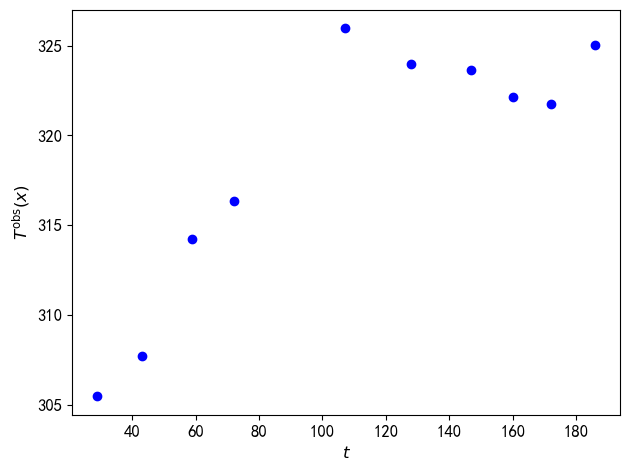

In [ ]:

fig1, ax1 = plt.subplots()
ax1.scatter(t_obs, data, color='blue')  # scatter(t,data,mc=:blue,msc=:match,label=false)
ax1.plot([], [])  # create an empty plot handle for further additions
ax1.set_xlabel(r"$t$")
ax1.set_ylabel(r'$T^{\mathrm{obs}}(x)$')
plt.tight_layout()

In [ ]:
import nlopt
a = np.zeros(2)  # Vector of unknown parameter values

def loglhood(data, tt, a, sigma):
    # function to evaluate the loglikelihood of the data stored in the vector data.
    y = np.zeros(len(tt))
    solver_ll=solver_function(a[0],a[1])
    y=solver_ll.Tt(tt)
    e = 0
    dist = stats.norm(loc=0, scale=sigma)  # define the additive Gaussian noise model with mean zero and standard deviation sigma
    e = dist.logpdf(data - y)   # compute the loglikelihood, here the distribution is dist,
                                # and the observations are the differences between the data and the solution of the model y
    return np.sum(e)

def Optimise(fun, θ0, lb, ub):
    # Optimize finds the values of parameters θ that maximise the objective function fun with lower bounds lb, and upper bounds ub
    # tomax = (θ,∂θ)->fun(θ)
    def tomax(θ, grad):
        # LN_NELDERMEAD is derivative-free so grad is ignored
        return fun(np.array(θ))
    #opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))#原优化器
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, len(θ0))#LN_COBYLA#LN_BOBYQA
    opt.set_max_objective(tomax)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_maxtime(3*60)
    xopt = opt.optimize(θ0)
    fopt = opt.last_optimum_value()
    return (xopt, fopt)  # Return (xopt, fopt)



In [ ]:

def funmle(a):
    # function to optimize for the MLE, this function returns the log-likelihood for the vector of parameters a = (Ta, k)
    return loglhood(data, t_obs,a, sigma)

#mu1min = 0.001; mu1max = 6; mu1min1 = -2; mu1max1 = 8; 
mu2min = 0.1; mu2max = 1.5; mu2min1 = 0.001; mu2max1 =2; 
alphamin=6;alphamax=15
θG = [ 0.9142,10.41]  # Initial estimate of the parameter values
lb = [mu2min,alphamin]
ub = [ mu2max,alphamax]
(xopt, fopt) = Optimise(funmle, θG, lb, ub)  # Call to NLopt


mu2mle = xopt[0]   # Store the MLE
alphamle=xopt[1]

fmle = fopt      # Store the log-likelihood at the MLE
print(f"MLE parameters:  mu2={mu2mle},alpha={alphamle}")
print(f"Log-likelihood at MLE: {fmle}")


MLE parameters:  mu2=0.8418245117187501,alpha=10.784908447265625
Log-likelihood at MLE: -21.42268423389846


Tmle_vals= [305.57794816 310.17708997 314.01695054 316.46094218 321.12651808
 322.81838238 323.90164689 324.22855569 324.2164027  324.02849776]


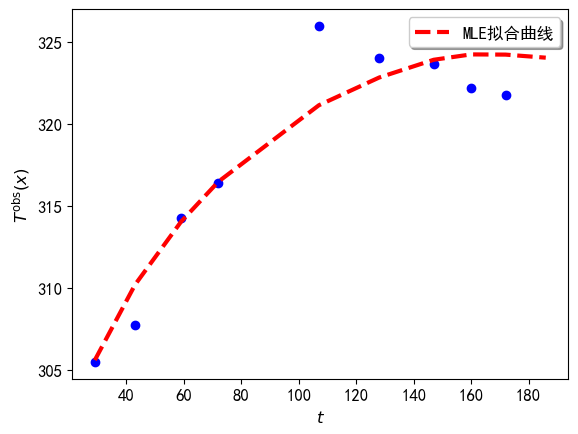

In [ ]:
solver_mle=solver_function( mu2mle,alphamle)
Tmle_vals = solver_mle.Tt(t_obs)
print("Tmle_vals=",Tmle_vals)
fig2, ax2 = plt.subplots()
ax2.scatter(t_obs, data, color='blue')  # scatter(t,data,mc=:blue,msc=:match,label=false)
# 追加新内容 
ax2.plot(t_obs,  Tmle_vals, linewidth=3, color='red', linestyle='--', label='MLE拟合曲线')  # 添加样式 
# 图例和样式增强 
ax2.legend(fontsize=12,  frameon=True, shadow=True, loc='upper right', bbox_to_anchor=(1.0, 1.0))
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r'$T^{\mathrm{obs}}(x)$')
# 强制刷新画布 
fig2.canvas.draw()   # 面向对象方式刷新 
# 最终显示 
plt.show() 





In [ ]:

df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold


In [ ]:
from tqdm import tqdm
def univariatemu2(mu2):
    # Function to compute the univariate profile likelihood for k
    def funk(a):
        alpha=a[0]#print("",type(alpha))#print("",type(mu2))
        return loglhood(data, t_obs ,np.array([mu2,alpha]), sigma)  # evaluate the log-likelihood at a specified value k
    θG_inner = [alphamle]  # Estimate of the nuisance parameter Ta
    lb_inner = [alphamin]  # Lower bound for the nuisance parameter Ta
    ub_inner = [alphamax]  # Upper bound for the nuisance parameter Ta
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)  # Call to NLopt
    return fopt_inner, xopt_inner  # Return the profile log-likelihood and value of the nuisance parameter
M =  50 
mu2range = np.linspace(mu2min, mu2max, M)
ff_mu2 = np.zeros(M)


for i in tqdm(range(M), desc="Processing"):
    ff_mu2[i] = univariatemu2(mu2range[i])[0]


Processing: 100%|██████████| 50/50 [1:28:14<00:00, 105.88s/it]


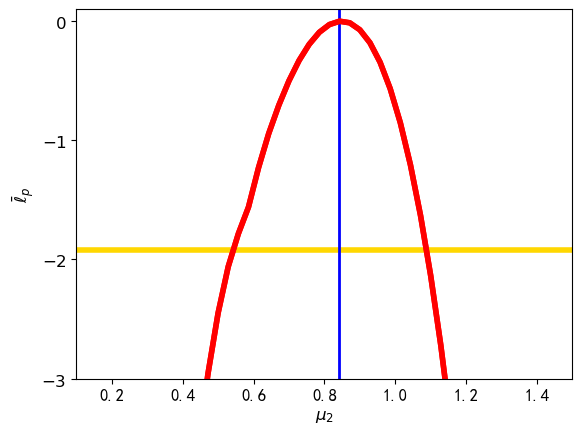

In [ ]:
from scipy.interpolate import UnivariateSpline
fig4, ax4 = plt.subplots()
ax4.axhline(y=llstar, linewidth=4, color='gold')  # Plot horizontal line for k profile likelihood
ax4.axvline(x=mu2mle, linewidth=2, color='blue')      # Plot vertical line at MLE k
sp3 = UnivariateSpline(mu2range, ff_mu2 - np.max(ff_mu2), k=3, w=np.ones(len(mu2range)), s=1/100)
yy_mu2 = sp3(mu2range)
ax4.plot(mu2range, yy_mu2, linewidth=4, color='red')
ax4.set_ylim(-3,  0.1)                               # 设置 y 轴范围 
ax4.set_xlim(mu2range[0],  mu2range[-1])               # 设置 x 轴范围 

ax4.plot(mu2range,  yy_mu2, linewidth=4, color='red')  # 仅绘图 
ax4.set_ylim(-3,  0.1)                               # 设置 y 轴范围 
ax4.set_xlim(mu2range[0],  mu2range[-1])               # 设置 x 轴范围 

#ax4.set_xticks([0.02,0.04,0.06,0.08])
#ax4.set_xticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"])
ax4.set_yticks([0,-1,-2,-3])
ax4.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"])
ax4.set_xlabel(r"${\mu}_2$")
ax4.set_ylabel(r"$\bar{\ell}_p$")
plt.draw()
plt.pause(0.001)


In [ ]:
def univariatealpha(alpha):
    # Function to compute the univariate profile likelihood for k
    def funk(a):
        mu2=a[0]
        return loglhood(data,  t_obs,np.array([mu2,alpha]), sigma)  # evaluate the log-likelihood at a specified value k
    θG_inner = [mu2mle]  # Estimate of the nuisance parameter Ta
    lb_inner = [mu2min]  # Lower bound for the nuisance parameter Ta
    ub_inner = [mu2max]  # Upper bound for the nuisance parameter Ta
    (xopt_inner, fopt_inner) = Optimise(funk, θG_inner, lb_inner, ub_inner)  # Call to NLopt
    return fopt_inner, xopt_inner  # Return the profile log-likelihood and value of the nuisance parameter

def f_k(x):
    return univariatealpha(x)[0]
alphamin=5;alphamax=20###########
alpharange = np.linspace(alphamin, alphamax, M)
ff_alpha = np.zeros(M)
for i in tqdm(range(M), desc="Processing"):
    ff_alpha[i] = univariatealpha(alpharange[i])[0]

Processing: 100%|██████████| 50/50 [2:33:57<00:00, 184.75s/it]  


 -1.920729410347062


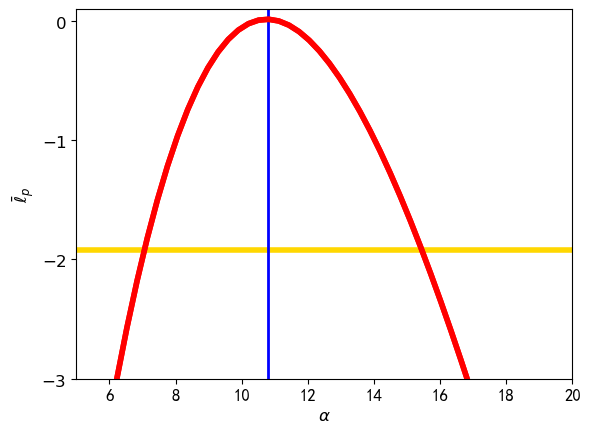

In [ ]:
df = 1  # degrees of freedom for the asymptotic threshold value for the univariate profile likelihood
llstar = -stats.chi2.ppf(0.95, df) / 2 
print("",llstar)


fig5, ax5 = plt.subplots()
ax5.axhline(y=llstar, linewidth=4, color='gold')  # Plot horizontal line for k profile likelihood
ax5.axvline(x=alphamle, linewidth=2, color='blue')      # Plot vertical line at MLE k
sp3 = UnivariateSpline(alpharange, ff_alpha - np.max(ff_alpha), k=3, w=np.ones(len(alpharange)), s=1/100)
yy_alpha = sp3(alpharange)
ax5.plot(alpharange, yy_alpha, linewidth=4, color='red')
ax5.set_ylim(-3,  0.1)                               # 设置 y 轴范围 
ax5.set_xlim(alpharange[0],  alpharange[-1])               # 设置 x 轴范围 

ax5.plot(alpharange,  yy_alpha, linewidth=4, color='red')  # 仅绘图 
ax5.set_ylim(-3,  0.1)                               # 设置 y 轴范围 
ax5.set_xlim(alpharange[0],  alpharange[-1])               # 设置 x 轴范围 

#ax4.set_xticks([0.02,0.04,0.06,0.08])
#ax4.set_xticklabels([r"$0.02$", r"$0.04$", r"$0.06$", r"$0.08$"])
ax5.set_yticks([0,-1,-2,-3])
ax5.set_yticklabels([r"$0$", r"$-1$", r"$-2$", r"$-3$"])
ax5.set_xlabel(r"${\alpha}$")
ax5.set_ylabel(r"$\bar{\ell}_p$")
plt.draw()
plt.pause(0.001)


In [ ]:
##之后用插值的方式去计算

In [ ]:
import numpy as np

# 假设 fmle, llstar, mu1range, ff_mu1 已由你的代码计算得出

# 第一步：计算轮廓对数似然比
ratio = ff_mu2 - fmle

# 第二步：找到满足 ratio >= llstar 的索引
indices = np.where(ratio >= llstar)[0]

# 检查是否找到置信区间
if len(indices) == 0:
    print("没有找到置信区间，请检查 mu2range 的范围或 ff_mu2 的计算是否正确")
else:
    # 第三步：找到置信区间的下限和上限
    mu1_min_ci = mu2range[indices[0]]    # 下限
    mu1_max_ci = mu2range[indices[-1]]   # 上限
    
    # 第四步：计算置信区间的长度
    ci_length = mu1_max_ci - mu1_min_ci
    
    # 输出结果
    print(f"95%置信区间的下限: {mu1_min_ci}")
    print(f"95%置信区间的上限: {mu1_max_ci}")
    print(f"置信区间的长度: {ci_length}")



95%置信区间的下限: 0.5571428571428572
95%置信区间的上限: 1.0714285714285714
置信区间的长度: 0.5142857142857142


In [ ]:
# Define interp_zero function
def interp_zero(x, y):
    zs = []
    n = len(x)
    for i in range(n - 1):
        x1, x2 = x[i], x[i + 1]
        y1, y2 = y[i], y[i + 1]
        if np.sign(y1) != np.sign(y2):
            m = (y2 - y1) / (x2 - x1)
            z = x1 - y1 / m
            zs.append(z)
    return zs

# Calculate log-likelihood ratio and difference from threshold
ratio = ff_mu2 - fmle
y = ratio - llstar

# Find intersection points
intersections = interp_zero(mu2range, y)

# Interpret results
if len(intersections) == 2:
    mu2_min_ci = min(intersections)
    mu2_max_ci = max(intersections)
    mu2_ci_length = mu2_max_ci - mu2_min_ci
    print(f"95% Confidence Interval Lower Bound: {mu2_min_ci:.4f}")
    print(f"95% Confidence Interval Upper Bound: {mu2_max_ci:.4f}")
    print(f"Confidence Interval Length: {mu2_ci_length:.4f}")
else:
    print("Expected 2 intersections, but found", len(intersections))
    print("Check mu1range span or ff_mu1 computation.")

95% Confidence Interval Lower Bound: 0.5418
95% Confidence Interval Upper Bound: 1.0882
Confidence Interval Length: 0.5465


In [ ]:
# Calculate log-likelihood ratio and difference from threshold
ratio2 = ff_alpha - fmle
y = ratio2 - llstar

# Find intersection points
intersections = interp_zero(alpharange, y)

# Interpret results
if len(intersections) == 2:
    alpha_min_ci = min(intersections)
    alpha_max_ci = max(intersections)
    alpha_ci_length = alpha_max_ci - alpha_min_ci
    print(f"95% Confidence Interval Lower Bound: {alpha_min_ci:.4f}")
    print(f"95% Confidence Interval Upper Bound: {alpha_max_ci:.4f}")
    print(f"Confidence Interval Length: {alpha_ci_length:.4f}")
else:
    print("Expected 2 intersections, but found", len(intersections))
    print("Check mu1range span or ff_mu1 computation.")

95% Confidence Interval Lower Bound: 7.0336
95% Confidence Interval Upper Bound: 15.4525
Confidence Interval Length: 8.4189


In [ ]:


df = 2  # degrees of freedom for the asymptotic threshold value
llstar = -stats.chi2.ppf(0.95, df) / 2  # log-likelihood threshold for the 95% threshold

M2 = 100  # Number of samples to be drawn
mu2sampled = np.zeros(M2)
alphasampled = np.zeros(M2)
lls = np.zeros(M2)
kount = 0
mu2min2=0.2; mu2max2=2
alphamin2=3; alphamax2=20

# 初始化进度条 
pbar = tqdm(total=M2, desc="Sampling MCMC Chains", dynamic_ncols=True)


while kount < M2:
    mu2g = np.random.uniform(mu2min2, mu2max2)  # Draw a sample of Ta at random within the box limits
    alphag = np.random.uniform(alphamin2, alphamax2)       # Draw a sample of k at random within the box limits
    llhf=(loglhood(data, t_obs, np.array([mu2g, alphag]), sigma) - fmle)
    if llhf >= llstar:#loglhood(data, t_obs,a, sigma)
        kount += 1
        lls[kount-1] = llhf
        mu2sampled[kount-1] = mu2g
        alphasampled[kount-1] = alphag
        pbar.update(1)   # 更新进度 
        pbar.set_postfix({"Current  μ2": mu2g, "α": alphag})  # 可选参数显示 

pbar.close() 


Sampling MCMC Chains: 100%|██████████| 100/100 [3:03:01<00:00, 109.82s/it, Current  μ2=0.664, α=14.9] 


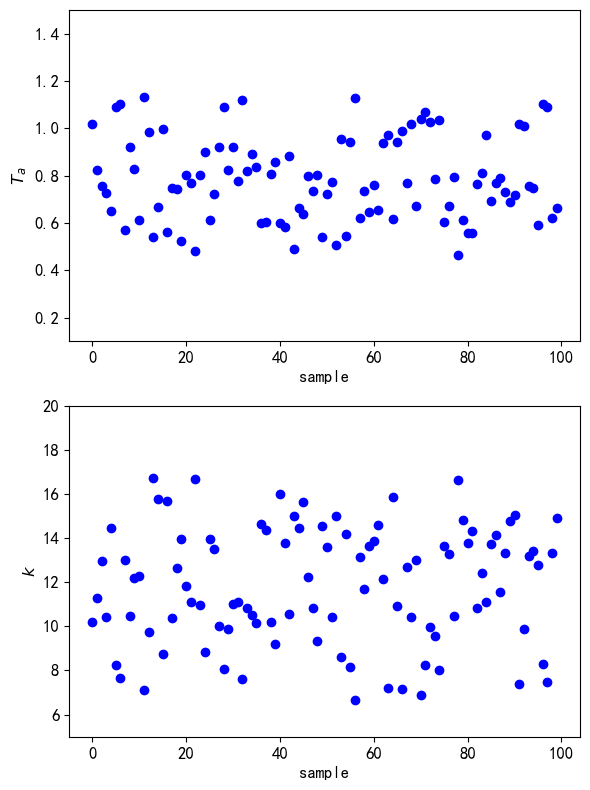

In [ ]:

# a1: plot samples of Ta
fig8, (ax8_top, ax8_bot) = plt.subplots(2, 1, figsize=(6,8))
ax8_top.scatter(range(M2), mu2sampled, color='blue')  # x-axis as sample index, y-axis value of Ta
ax8_top.set_xlabel("sample")
ax8_top.set_ylabel(r"$T_a$")
ax8_top.set_ylim(mu2min, mu2max)
# a2: plot samples of k
ax8_bot.scatter(range(M2), alphasampled, color='blue')
ax8_bot.set_xlabel("sample")
ax8_bot.set_ylabel(r"$k$")
ax8_bot.set_ylim(alphamin, alphamax)
plt.tight_layout()
plt.draw()
plt.pause(0.001)
plt.show(block=False)


In [ ]:
#np.savez('sampled_parameters.npz',  mu2=mu2sampled, alpha=alphasampled)

In [ ]:
n_points=10
ttt=np.linspace(0,tmax,n_points)
lower = np.full(len(ttt), 1000)  # Define vector on the fine discretisation of t that will store the lower limit of the prediction interval
upper = np.zeros(len(ttt))             # Define vector on the fine discretisation of t that will store the upper limit of the prediction interval
q_low = stats.norm.ppf(0.05, loc=0, scale=sigma)
q_high = stats.norm.ppf(0.95, loc=0, scale=sigma)
# 外层循环：参数样本处理（主进度条）
for i in tqdm(range(M2), desc="Sampling Parameters [M2]", position=0, colour='green'):
    # 定义温度求解函数（每个参数样本独立）
    def Ts(t_val):
        solver_Ts=solver_function( mu2sampled[i],alphasampled[i])
        T_vals = solver_Ts.Tt(t_val)
        return T_vals
    for j in range(len(ttt)):
        val_low = Ts(ttt[j]) + q_low  # lower bound of the noise model at time tt[j]
        if val_low < lower[j]:
            lower[j] = val_low
        val_high = Ts(ttt[j]) + q_high  # upper bound of the noise model at time tt[j]
        if val_high > upper[j]:
            upper[j] = val_high


Sampling Parameters [M2]: 100%|██████████| 100/100 [5:38:46<00:00, 203.27s/it] 


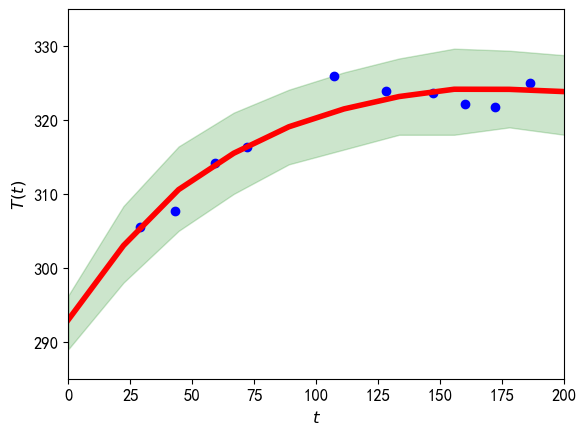

In [ ]:

# Plot the prediction interval region and the MLE prediction
fig9, ax9 = plt.subplots()
ax9.fill_between(ttt, lower, upper, color='green', alpha=0.20)  # Plot the region between lower and upper bounds
# Superimpose MLE prediction
ax9.plot(ttt, solver_mle.Tt(ttt), linewidth=4, color='red')
ax9.set_xlabel(r"$t$")
ax9.set_ylabel(r"$T(t)$")
ax9.set_xlim(0, tmax)
ax9.set_ylim(285, 335)
#ax9.set_xticks([0,25,50,75,100])
#ax9.set_xticklabels([r"$0$", r"$25$", r"$50$", r"$75$", r"$100$"])
#ax9.set_yticks([0,50,100,150,200])
#ax9.set_yticklabels([r"$0$", r"$50$", r"$100$", r"$150$", r"$200$"])
#t_obs=[ 29 , 43 , 59 , 72, 107 ,128, 147 ,160 ,172 ,186]
ax9.scatter(t_obs, data, color='blue')

plt.draw()
plt.pause(0.001)
plt.show(block=False)